# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import re
import nltk
import csv
import time
from tqdm import tqdm
from IPython.display import display, clear_output
import os, os.path
from google.colab import files
import shutil
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download('punkt')

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.stem import *
# PyStemmer
! pip install pystemmer
import Stemmer

# Whoosh
! pip install whoosh
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
from whoosh import scoring
from whoosh.analysis import Filter
import tempfile

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import mutual_info_score
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



     |████████████████████████████████| 563kB 7.8MB/s 
  Created wheel for pystemmer: filename=PyStemmer-2.0.1-cp37-cp37m-linux_x86_64.whl size=425028 sha256=3815b15db95bcdfda43ddcc14bb27094c001b353da1ea49d228dd2834b969416
  Stored in directory: /root/.cache/pip/wheels/f3/3c/11/ee323a09706e17a649c2730bd8819b06e887411ff7507acf7a
Successfully built pystemmer
     |████████████████████████████████| 471kB 8.4MB/s 


In [3]:
# Read metadata, limit to columns we need and drop duplicated papers
try:
    metadata = pd.read_csv("metadata.csv")
except:
    # Upload zipped file for efficiency.  Unzip it here
    ! unzip metadata.zip
    metadata = pd.read_csv("metadata.csv")
metadata = metadata[['title','abstract','authors','publish_time']]
metadata = metadata.drop_duplicates(subset='abstract', keep="first")
metadata = metadata.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
metadata.isna().sum()

title             43
abstract           1
authors         2653
publish_time     187
dtype: int64

# 1. Data Cleaning

In [5]:
# First we will index our research papers for querying (the NULL title/abstracts will get dropped during this process)
# Querying is advantageous vs boolean searches as it is more flexible and capable of returning a wider range of relevant documents
# We are using whoosh to handle the indexing.  We can define a series of cleaning steps we will apply while indexing

## 1.0 Whoosh Filters (Tokenizing, Stopwords, Stemming)

In [6]:
# The filters we are applying include a RegexFilter to handle words, a lowercase filter, a intra-word filter, a stop words filter and finally a snowball stemmer
# The stemmer will insure our feature vectors are more adept at filtering for relevant documents (for example it will see 'vaccines','vaccination','vaccinating', etc. as the same token 'vaccin')
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
myFilter = RegexTokenizer() | LowercaseFilter() | IntraWordFilter() | StopFilter() | CustomFilter(SnowballStemmer("english").stem)

## 1.1 Define Whoosh Schema and Index

In [7]:
# Next we will create our schema and index for whoosh
# Indexing our corpus allows for faster and more efficient querying
def createIndex(schema):
    # Generate a directory for the index
    if not os.path.exists("indexDir"):
        os.mkdir("indexDir")

    # Create and return the index
    return index.create_in("indexDir", schema)

# The schema has 3 data fields.  The research paper index in the metadata dataframe, the title and the abstract
# This is also where we pass our custom filter from before
load_index = True
if load_index == False:
    mySchema = Schema(index=ID(stored=True),title=TEXT(analyzer=myFilter,stored=True),abstract=TEXT(analyzer=myFilter,stored=True))
    myIndex = createIndex(mySchema)

# Define a function for iteratively adding research papers to our index
# Note this is a ~2hr runtime
def AddToIndex(df,index_object,columns=['title','abstract']):
    writer = writing.BufferedWriter(index_object, period=None, limit=1000)
    t = time.time()
    corpus = df[columns].values
    N = len(corpus)
    for docnum, doctext in enumerate(corpus):
        clear_output(wait=True)
        display('Percent Completion: '+"{:.2f}".format(100*docnum/N) + ' >>> Minutes Elapsed: '+"{:.2f}".format((time.time() - t)/60))
        try:
            writer.add_document(index=str(docnum),title=doctext[0],abstract=doctext[1])
        except:  
            1  
    print("Done Indexing")
    writer.close()


## 1.2 Index Corpus

In [8]:
# Add the files to the index and immediately save when we are done
# Note exporting the index is also a time consuming process

load_index = True

if load_index == False:
    AddToIndex(metadata,myIndex,['title','abstract'])
    shutil.make_archive('indexDir', 'zip', 'indexDir')
    files.download("indexDir.zip")
else:
    ! unzip indexDir.zip -d indexDir
    myIndex = index.open_dir('indexDir')

Archive:  indexDir.zip
  inflating: indexDir/MAIN_ftwbz8431dnl422n.seg  
  inflating: indexDir/_MAIN_324.toc  
  inflating: indexDir/MAIN_WRITELOCK  
  inflating: indexDir/MAIN_ukxpo230sqnq9s6z.seg  
  inflating: indexDir/MAIN_1snnc7pr1z6h1fiz.seg  
  inflating: indexDir/MAIN_1mbnpxj0xnzyv74u.seg  
  inflating: indexDir/MAIN_ty30ni40w4gkz5dk.seg  
  inflating: indexDir/MAIN_vrjbjirhzh3rl76m.seg  


## 1.3 Query Corpus with Our Research Topic: "Effectiveness of Therapeutics on COVID19"

In [9]:
# Setup query capability on our index
# Here we will search for our topic of interest and save the results for further evaluation
# Note we can query both the title and abstract
def query_corpus(field,query,limit=None):
    qp = QueryParser(field, schema=myIndex.schema)
    q = qp.parse(query)
    searcher = myIndex.searcher(weighting=scoring.TF_IDF)
    results = searcher.search(q,limit=limit)
    return results

In [10]:
# Our research topic is the effectiveness of therapeutics on COVID19
results = query_corpus("abstract","effectiveness of therapeutics on COVID19")

# Define index for filtering metadata
query_idx = [int(x['index']) for x in results]
df = metadata.loc[metadata.index.isin(query_idx)].copy()

In [11]:
# We get 4443 results when we query the abstract field for this topic (alternatively we could query the title field for a more focused result set)
# Working with this reduced dataset of articles specific to our research topic is more efficient than working with the full ~400k article corpus
results

<Top 4443 Results for And([Term('abstract', 'effect'), Term('abstract', 'therapeut'), Term('abstract', 'covid'), Term('abstract', '19')]) runtime=1.3544129590000011>

## 1.4 Process Files Relevant to Our Research Topic

In [12]:
# Define a Pipeline Class to clean the reduced dataset
class Pipeline():
    def __init__(self,df):
        self.df = df
        self.partition = None # If we are processing a large dataframe we can apply partitions to reduce memory usage
        self.stop = set(stopwords.words('english')) # NLTK stopwords
        self.stemmer = SnowballStemmer('english') # NLTK snowball stemmer
        self.pystemmer = Stemmer.Stemmer('english') # pystemmer stemmer for larger datasets (works on lists of tokens rather than individual tokens)
        # Define our grammar pattern for filtering through Part of Speech (POS) tagged tokens
        self.grammar = r"""
                          P1:
                              {<JJ.*>*<NN.*>}  # Adjective terminated with Noun
                          P2:
                              {<VB.*|RB.*>*<RB.*|JJ.*>} # Verb|Adverb terminated with Verb|Adverb
                          NP:
                              {<P1>}  # Either of the above patterns
                              {<P2>}
                      """
        self.tagger = PerceptronTagger() # NLTK POS tagger
        self.pos_tag = self.tagger.tag
        self.chunker = nltk.RegexpParser(self.grammar) # NLTK chunker for parsing POS tags
        self.topk = 2000 # Top K Words for TFIDF Vectors
        
        # SKLearn TFIDF Vectorizers (for normal tokens as well as phrase tokens identified by our pos tags)
        self.TFIDF = TfidfVectorizer(
            analyzer='word',
            tokenizer=self.dummy_fun,
            preprocessor=self.dummy_fun,
            token_pattern=None,
            max_features=self.topk
        )
        self.TFIDF_phrases = TfidfVectorizer(
            analyzer='word',
            tokenizer=self.dummy_fun,
            preprocessor=self.dummy_fun,
            token_pattern=None,
            max_features=self.topk
        )
    
    def datetime(self):
        """
        Process publish time into pandas datetime format
        """
        self.df['datetime'] = pd.to_datetime(self.df.publish_time)
        self.df['year'] = self.df['datetime'].dt.year
        self.df = self.df.loc[self.df.year>=2020].copy() # Only want COVID relevant articles

    def partition_df(self,n_incr=10):
        """
        Partition full dataframe into 10 partitions for processing with less memory
        """
        idx = list(metadata.index)
        increment = np.floor(len(idx) / n_incr)
        increments = np.arange(0,len(idx),increment)
        increments[-1] = len(idx)
        self.partition = {}
        for i,incr in enumerate(increments[:-1]):
            idx_slice = np.arange(incr,increments[i+1])
            self.partition[i] = metadata.loc[metadata.index.isin(idx_slice)].copy()

    def concat(self):
        """
        Concatenate partitioned dataframe for output
        """
        self.df = pd.concat(self.partition).reset_index().drop(['level_0','level_1'],axis=1)

    def tokenize(self,column,partition=False,verbose=False):
        """
        Apply regex word tokenization, stopword filters, lowercase filters and min-length filters
        """
        if verbose==True:  print("tokenize " + column)
        if partition==True:
            for p in tqdm(self.partition.keys()):
                self.partition[p][column] = self.partition[p][column].fillna("")
                self.partition[p][column+'_tokens'] = self.partition[p][column].apply(lambda x:[token.lower() for token in re.findall(r'\w+',str(x)) if token.lower() not in self.stop and len(token) > 2])
        else:
            self.df[column] = self.df[column].fillna("")
            self.df[column+'_tokens'] = self.df[column].apply(lambda x:[token.lower() for token in re.findall(r'\w+',x) if token.lower() not in self.stop and len(token) > 2])

    def pos(self,token_column,phrase_length=2,verbose=False):
        """
        Apply Part-of-Speech (POS) tagging on tokens
        Phrase length declares the minimum number of tokens required for a phrase
        """
        if verbose==True:  print("Tagging " + token_column)
        corpus = self.df[token_column].values
        phrases = []
        for doc_tokens in corpus:
            tagged_tokens = self.pos_tag(doc_tokens) # get POS tags
            tree = self.chunker.parse(tagged_tokens) # parse tags with grammar
            leaf = self.get_NP(self.get_tuple_terms(tree,phrase_length)) # get tree leaves
            phrases.append(leaf)
        self.df[token_column+"_phrases"] = phrases

    def leaves(self,tree):
        """
        Finds Noun/Verb Phrase leaf nodes of a chunk tree
        """
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB' or t.label()=='NN'):
            yield subtree.leaves()

    def get_tuple_terms(self,tree,phrase_length=1):
        """
        Filters phrases for min phrase length
        Returns a generator object
        """
        for leaf in self.leaves(tree):
            term_tuple = tuple(x[0] for x in leaf)
            # Phrase only
            if len(term_tuple)>=phrase_length:
                yield term_tuple

    def get_NP(self,tuple_terms):
        """
        Converts generator object to list
        """
        return [x for x in tuple_terms]

    def stem(self,column,partition=False,verbose=False):
        """
        Apply NLTK snowball stemming to tokens
        """
        if verbose==True: print("stem " + column)
        if partition==True:
            for p in tqdm(self.partition.keys()):
                self.partition[p][column] = self.partition[p][column].apply(lambda x: [self.stemmer.stem(word) for word in x])
        else:
            self.df[column] = self.df[column].apply(lambda x: [self.stemmer.stem(word) for word in x])

    def pystem(self,column,partition=False,verbose=False):
        """
        Apply pystemmer stemming to tokens (parses list of tokens rather than individual tokens like the NLTK stemmer)
        """
        if verbose==True: print("pystem " + column)
        if partition==True:
            for p in tqdm(self.partition.keys()):
                self.partition[p][column+"_stem"] = self.partition[p][column].apply(lambda x: self.pystemmer.stemWords(x))
        else:
            self.df[column+"_stem"] = self.df[column].apply(lambda x: self.pystemmer.stemWords(x))

    def flag(self,column,keyword,partition=False,verbose=False):
        """
        Create a Boolean flag for a keyword
        """
        if verbose==True: print("flag " + column)
        if partition==True:
            for p in tqdm(self.partition.keys()):
                self.partition[p]['flag_'+column.split("_")[0]+'_'+keyword] = self.partition[p][column].apply(lambda x: int(keyword in x))
        else:
            self.df['flag_'+column.split("_")[0]+'_'+keyword] = self.df[column].apply(lambda x: int(keyword in x))

    # Vectorizer Functions
    def dummy_fun(self,doc):
        """
        Allows SKLearn TFIDF Vectorizer to accept pre-tokenized inputs
        """
        return doc  
    
    def tfidf(self,column='abstract'):
        """
        Apply SKLearn TFIDF transformations
        """
        tokens_abstract = self.df[column+"_tokens"].values
        tfidf = self.TFIDF.fit(tokens_abstract) 
        tfidf_abstract = tfidf.transform(tokens_abstract) 
        self.df['tfidf_'+column] = tfidf_abstract

    def tfidf_phrases(self,column='abstract'):
        """
        Apply SKLearn TFIDF transformations to the phrases identified by our grammar pattern
        """
        tokens_abstract = self.df[column+"_tokens_phrases"].values
        tfidf = self.TFIDF_phrases.fit(tokens_abstract) 
        tfidf_abstract = tfidf.transform(tokens_abstract) 
        self.df['tfidf_'+column+'_phrases'] = tfidf_abstract

    def run(self):
        """
        Run all processing functions
        """
        self.datetime()
        self.tokenize('title')
        self.tokenize('abstract')
        self.pystem('title_tokens')
        self.pystem('abstract_tokens')
        self.pos('title_tokens')
        self.pos('abstract_tokens')
        self.tfidf()
        self.tfidf_phrases()

In [13]:
# Apply pipeline to our query filtered metadata df
pipeline = Pipeline(df)
pipeline.run()
df = pipeline.df.copy()

# 2. Data Visualization and Exploratory Data Analysis

## 2.1 Wordcloud

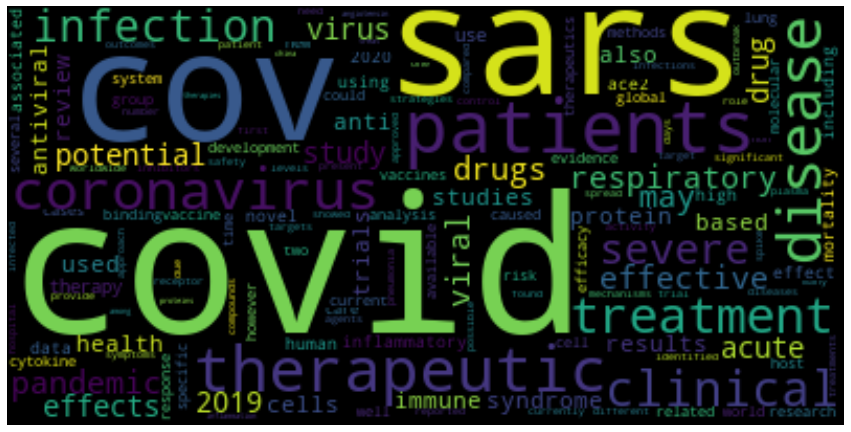

In [14]:
# A wordcloud is useful for evaluating the results of our initial query
# We are interested in therapeutic effectiveness on covid, does the word cloud represent our query?
# We can see keywords such as covid, clinical, studies, treatment, therapeutic, effective, etc. show up suggesting our query was effective
def getWordFreq(df,column='abstract_tokens'):
    """
    Function for counting word frequency across the corpus    
    """
    counter = Counter()
    corpus = df[column].values
    for text in corpus:
            text = [str(x) for x in text if len(x)>2]
            counter.update(text)
    return counter

# Calculate word frequencies within the abstract field of the metadata and pass to WordCloud()
abstract_word_freq = getWordFreq(df)
abstract_wordcloud = WordCloud().generate_from_frequencies(abstract_word_freq)
fig = plt.figure(figsize=(15,10))
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

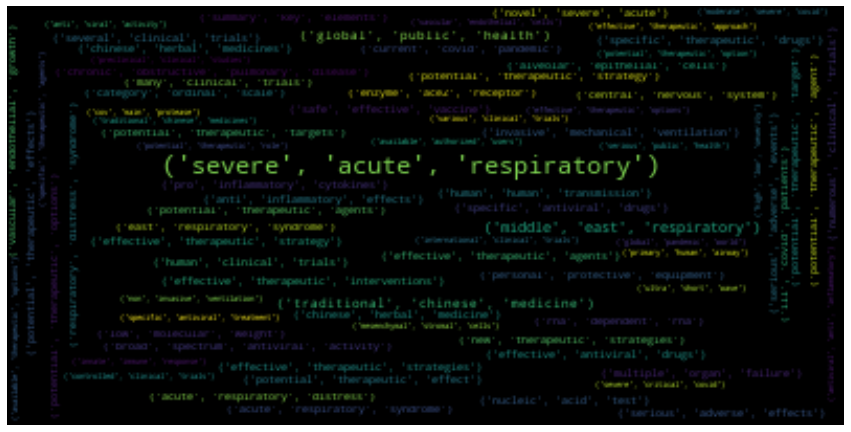

In [16]:
# Calculate phrase frequencies within the abstract field of the metadata and pass to WordCloud()
# Analysing the word phrases rather than the words is another effective way to identify the effectivness of our query
# Phrases such as 'severe acute respiratory', 'several clinical trials', 'safe effective vaccine', 'effective therapeutic strategy', show up
# This suggests out query effectively returned relevant results
abstract_phrase_freq = getWordFreq(df,column="abstract_tokens_phrases")
abstract_phrasecloud = WordCloud().generate_from_frequencies(abstract_phrase_freq)
fig = plt.figure(figsize=(15,10))
plt.imshow(abstract_phrasecloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2.2 Timeseries

In [18]:
# Add month column
df['month'] = df['datetime'].dt.month
# Group by Year-Month and count articles
ts = df.groupby(by=['year','month'])[['title']].count().reset_index()
ts['date'] = ts['year'].astype(int).astype(str)+"_"+ts['month'].astype(str)

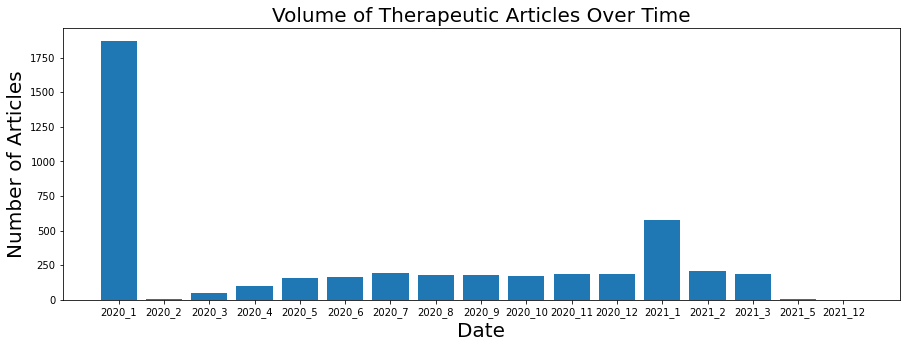

In [19]:
# Timeseries analysis is good for understanding the recency of this data
# If most articles are from early in the pandemic they may be less valuable
# More recent articles presumably have more data / experience / clinical trials with the virus
# We can see 2020 January had the greatest volume of articles which is interesting considering COVID hit the mainstream later
fig = plt.figure(figsize=(15,5))
plt.bar(ts.date,ts.title)
plt.title('Volume of Therapeutic Articles Over Time',size=20)
plt.xlabel('Date',size=20)
plt.ylabel('Number of Articles',size=20)
plt.show()
#df['datetime'].hist()

In [20]:
# Upon deeper inspection we can see all these articles have '2020-01-01' as their date suggesting erroneous entries
# We speciifcally queried for COVID19 articles which only hit the mainstream near the end of 2020Q1 which is why this volume of articles in January stood out
df.loc[(df['year']==2020)&(df.month==1)]['datetime'].value_counts()

2020-01-01    1870
Name: datetime, dtype: int64

## 2.3 Therapeutics Research Volume

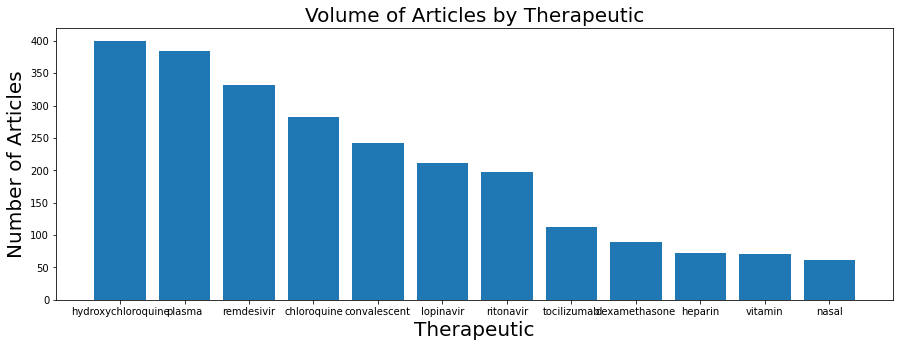

In [21]:
# We should understand which therapeutics are being researched the most / are most prevalent in our corpus
# First we can find a list of therapeutics from an online source
# https://www.raps.org/news-and-articles/news-articles/2020/3/covid-19-therapeutics-tracker
thera_name = ['vitamin','favilavir','remdesivir','dexamethasone','hydroxychloroquine','chloroquine','lilly','bamlanivimab','etesevimab','casirivimab','imdevimab','plasma','baracitinib','regdanvimab','niclosamide',
              'regkirona','azd7442','lenzilumab','bamlanivimab','veklury','ivermectin','niclocide','zyesami','leronlimab','eliquis', 'apixaban','bucillamine','colchicine','mitigare','colcrys',
              'bamlanivimab','etesevimab','casirivimab','imdevimab','olumiant','baricinix','ensovibep','actemra','tocilizumab','pyramax','artesunate','pyronaridine','molnupiravir','abx464',
              'carragelose','otilimab','avigan','favilavir','avifavir','kevzara','sarilumab','metformin','glucophage','glumetza','riomet','ptc299','pepcid','famotidine']

# Define global stopwords (outside of the pipeline class used earlier)
stop = set(stopwords.words('english'))

# Open the table from the online source and append the therapeutic drug name table fields to a list
with open('thera_text.txt',"r") as f:
    thera_file = csv.reader(f,delimiter='\t')
    thera_array = []
    for line in thera_file:
        thera_array.append(line[1])

# Apply tokenization to our therapeutic names to ensure they match our processed corpus text
thera_tokens = []
for line in thera_array:
    tokens = [token.lower() for token in re.findall(r'\w+',line) if token.lower() not in stop and len(token) > 2]
    thera_tokens += tokens

# Add additional therapeutic drugs of interest not included
thera_tokens += ['hydroxychloroquine','chloroquine','vitamin']

# Count incidence rate of therapeutic drugs
thera_count = {}
for thera in thera_tokens:
    thera_count[thera] = 0
    for text in df.abstract_tokens.values:
        if thera in text:
            thera_count[thera] += 1

# Clean results and create bar plot
thera_count = pd.DataFrame.from_dict(thera_count,orient='index',columns=['cnt'])
thera_count = thera_count.loc[thera_count.cnt>50].sort_values(by='cnt',ascending=False).copy() # Filter for top results
thera_count = thera_count.loc[~thera_count.index.isin(['2020','100','pro','others','cov2'])].copy()
#thera_count = thera_count.loc[thera_count.cnt>5].copy()
fig = plt.figure(figsize=(15,5))
plt.bar(list(thera_count.index),thera_count['cnt'].values)
plt.title('Volume of Articles by Therapeutic',size=20)
plt.xlabel('Therapeutic',size=20)
plt.ylabel('Number of Articles',size=20)
fig.show()

In [22]:
# Unsurprisingly hydroxychloroquine is the leading therapeutic, this is likely do to the politicization of this particular drug, something which should be kept front of mind when evaluating results
# We can also see remdesivir, lopinavir, dexamethasone and heparin are some other widely researched therapeutic options

# 3. Model Selection and Fitting to Data

## 3.1 Classifying Effectiveness of Therapeutics

In [23]:
# We will use the supplementary files from the Kaggle dataset
# Kaggle Dataset 'archive.zip' https://bit.ly/3fzhlhD
# archive.zip/Kaggle/target_tables/7_therapeutics_interventions_and_clinical_studies/What is the efficacy of novel therapeutics being tested currently_.csv
# This table provides a target value we can leverage for a classification model.  Clinical Improvement (Y/N) informs us of the effectiveness of the therapeutic
# Nulls are labelled as 'FT' for 'Further Testing'
gt = pd.read_csv('thera_ground_truth.csv')
gt = gt[['Study','General Outcome/Conclusion Excerpt','Clinical Improvement (Y/N)']].copy()
gt.columns = ['study','outcome','effective']
gt.loc[gt.effective=='-','effective'] = 'FT'

# Note that our ground truth only consists of 34 samples
gt.shape

(34, 3)

In [24]:
# It is also skewed towards 'Y' or effectiveness
gt.effective.value_counts()

Y     18
FT    11
N      5
Name: effective, dtype: int64

In [25]:
gt[['study','outcome','effective']].head()

,study,outcome,effective
0,Umifenovir treatment is not associated with im...,Thirty-three out of 45 (73%) patients in the u...,N
1,Alpha-1 adrenergic receptor antagonists for pr...,We previously demonstrated that alpha-1 adrene...,Y
2,"A Randomized, Single-blind, Group sequential, ...",The results suggested ALA treatment might be a...,Y
3,Fast Identification of Possible Drug Treatment...,Taking the advantage of a recently released cr...,FT
4,An exploratory randomized controlled study on ...,"The primary endpoints, the average time of pos...",N


In [26]:
# Apply our pipeline to this dataset
gt_pipeline = Pipeline(gt) #(balanced_gt)
gt_pipeline.tokenize('outcome')
gt_pipeline.pystem('outcome_tokens')
gt_pipeline.pos('outcome_tokens')
gt_pipeline.tfidf(column='outcome')
gt_pipeline.tfidf_phrases(column='outcome')
gt = gt_pipeline.df.copy()

In [27]:
# Fit a simple logistic regression with 3-fold cross-validation, regression is preferable for low sample datasets
# We also want to leverage logistic regressions probabilistic predictions
# Averaging probabilities across articles will give an 'ensemble' view of the effectiveness of the drug which is less skewed by poor studies
lr = LogisticRegressionCV(cv=3,random_state=1)
gt_X = gt.tfidf_outcome.values[0]
gt_y = gt.effective.values
gt_X_train, gt_X_test, gt_y_train, gt_y_test = train_test_split(gt_X, gt_y, test_size=0.2, random_state=10)
lr.fit(gt_X_train,gt_y_train)
accuracy_score(y_true=gt_y_test,y_pred=lr.predict(gt_X_test))

0.8571428571428571

In [28]:
# Define therapeutics of interest
therapeutics = ['hydroxychloroquine','remdesivir','lopinavir','apixaban','dexamethasone','heparin']

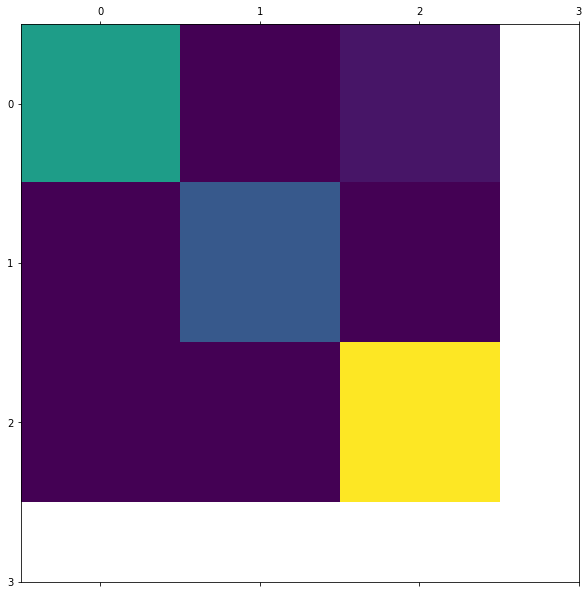

In [29]:
# We will show a confusion matrix to evlaluate our model
# NOTE: Again it is important to note that this is proof of concept
# Because our test-set is small, we will show a confusion-matrix over all samples 
# (showing the confusion matrix here just for demonstration while fully recognizing the flaws in this, the model can overfit to training samples and this will overstate accuracy)
# This confusion matrix mainly shows our model does not struggle with the class imbalance problem
# 0 is FT, 1 is N and 3 is Y
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

plot_confusion_matrix(confusion_matrix(y_true=gt_y,y_pred=lr.predict(gt_X)))

In [31]:
# For each therapeutic of interest flag its occurence in our queried metadata
# For each article with a mention of the therapeutic predict the effectiveness using our logistic regression model, again leveraging the predicted probabilities here
thera_effect = {}
for drug in therapeutics:
    try:
        pipeline.flag('abstract',drug)
        df = pipeline.df.copy()
        df = df.reset_index(drop=True)
        df = df.loc[df['flag_abstract_'+drug]==1].copy()
        vector = df.tfidf_abstract.values[0]
        pred = pd.DataFrame(lr.predict_proba(gt_X),columns=['FT','N','Y'])
        df = df.join(pred)
        thera_effect[drug] = df[['Y','N','FT']].mean().to_dict()
    except:
        print("No instances of "+drug)

In [32]:
# The reason these cross-article classifier results are so appealing is that they average predicted probabilities (rather than classes)
# The mean predicted probability of Y, N, FT across all articles gives an 'ensemble' view of the actual effectiveness
# This approach is especially useful for a polarized therapeutic like hydroxychloroquine where we can see how the articles collectively skew on it
# With a larger training set this classifier would be extremely valuable
gt_results = pd.DataFrame(thera_effect).T
gt_results

,Y,N,FT
hydroxychloroquine,0.500099,0.498968,0.000934
remdesivir,0.002651,0.498343,0.499006
lopinavir,0.002236,0.996555,0.001209
apixaban,0.758787,0.056316,0.184897
dexamethasone,0.002764,0.000618,0.996619
heparin,0.758787,0.056316,0.184897


In [35]:
# We observe the polarization of hydroxychloroquine with this model
# It also sees apixaban and heparin as effective while lopinavir is not
# Remdesivir and dexamethasone both warrant further testing / investigation
# Not drawing final conclusions from this proof-of-concept model, however it will be interesting to contrast with our findings later

## 3.2 Therapeutic Effectiveness Deep Dive: Clustering

In [37]:
# Clustering on this dataset can uncover hidden subgroups of articles which reach similar conclusions / pertain to a specific nuance of the query (i.e. negative side effects)
# Lets specifically query the 'title' field (as opposed to the abstract) as this will provide a much more focused set of results 
#results1 = query_corpus("title","effectiveness of dexamethasone for COVID19",20)
results1 = query_corpus("title","effectiveness of therapeutics for COVID19")

In [38]:
# Review number of results
results1

<Top 89 Results for And([Term('title', 'effect'), Term('title', 'therapeut'), Term('title', 'covid'), Term('title', '19')]) runtime=0.5018443279996063>

In [39]:
# Define index for filtering metadata
query_idx1 = [int(x['index']) for x in results1]
df1 = metadata.loc[metadata.index.isin(query_idx1)].copy()
# Apply pipeline to our query filtered metadata df
pipeline1 = Pipeline(df1)
pipeline1.run()
df1 = pipeline1.df.copy()

### Dimensionality Reduction

In [40]:
# Apply Truncated SVD dimensionality reduction (works with sparse matrics)
# Dimensionality reduction will allow for faster clustering on larger query results
# When working with a query with 1000s of results this is significant and keeping this functionality allows this text mining process to scale
def dimension_reduction(df,n_dim):
    svd = TruncatedSVD(n_components=n_dim)
    tfidf_abstract = df.tfidf_abstract.values[0]
    svd.fit(tfidf_abstract)
    print(("explained variance:",svd.explained_variance_ratio_.sum()))
    tfidf_abstract_svd = svd.transform(tfidf_abstract)
    return svd, tfidf_abstract_svd

In [41]:
# We want to determine the threshold number of components to use in order to retain satsifactory variance
# Calculate for all dimensions up to N
svd,_ = dimension_reduction(df1,889)

('explained variance:', 0.9999999999999996)


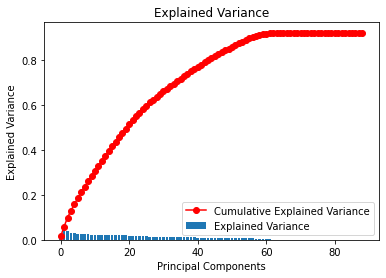

In [42]:
# Plot the Explained Variance
# We can see any individual component explains negligible variance and a large number are required to retain ~80-90% variance
plt.bar(range(len(svd.explained_variance_)), svd.explained_variance_, label='Explained Variance')
plt.plot(np.cumsum(svd.explained_variance_), 'r-o', label='Cumulative Explained Variance')
plt.legend()
plt.title('Explained Variance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.show()

In [44]:
# From the plot above we can see that 60 components provides an excellent representation of the data
svd,tfidf_abstract_svd = dimension_reduction(df1,60)

('explained variance:', 0.9921039449477468)


In [45]:
# Select Number of Clusters: Iterate over 1-10 and Calculate the RSS
from sklearn.cluster import KMeans
kmeans = {}
kmeans_rss = {}
for k in range(1,15):
    kmeans[k] = KMeans(n_clusters=k,random_state=1)
    kmeans[k].fit(tfidf_abstract_svd)
    kmeans_rss[k] = kmeans[k].inertia_

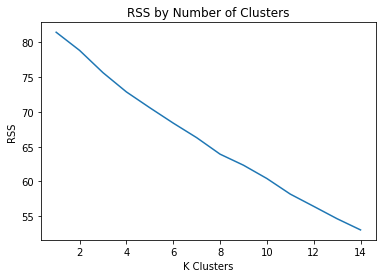

In [47]:
# We can plot the RSS against the number of clusters and look for 'knees' in the graph
# These suggest values for our k parameter
# We can see 8 has a slight knee, however there are no obvious breaks suggesting weakly defined clusters
# Other query results have shown stronger clusters (just not this specific example)
plt.title('RSS by Number of Clusters')
plt.xlabel('K Clusters')
plt.ylabel('RSS')
plt.plot(pd.DataFrame.from_dict(kmeans_rss,orient='index',columns=['rss']))

In [48]:
def getTopKWords(df, kwords, column='abstract_tokens'):
    """
    Function for returning the topk words from a corpus
    """
    counter = Counter()
    corpus = df[column].values
    for text in corpus:
            text = [x for x in text if len(x)>2 and x not in stop]
            counter.update(text)
    topk = counter.most_common(kwords)
    return topk

In [49]:
# get Top K mutual information terms from the dataframe
def getMI(df, label, n_scores, label_column='label', phrases=False):
    """
    Function for calculating the Mutual Information scores of tokens
    These will be calculated agains the labels from KMeans clustering
    This will return the tokens which provide the most information regarding any given cluster
    """
    df = df.reset_index()
    df = df.loc[df[label_column]==label].copy() # Filter on the cluster labels
    idx = list(df.index)
    miScore = []
    col = 'tfidf_abstract'
    if phrases==True: # Check if we are using Noun/Verb phrases from POS tagging
        col+='_phrases'
    tfidf_vector = df[col].values[0] # Sparse TFIDF matrix
    # For each feature, compare the feature vector to the label vector and calculate the MI
    if phrases==False:
        for word in pipeline1.TFIDF.get_feature_names():
            word_vector = tfidf_vector[:,pipeline1.TFIDF.vocabulary_[word]].toarray()[idx,0]
            miScore.append([word]+[mutual_info_score(df[label_column], word_vector)])
    else:
        for word in pipeline1.TFIDF_phrases.get_feature_names():
            word_vector = tfidf_vector[:,pipeline1.TFIDF_phrases.vocabulary_[word]].toarray()[idx,0]
            miScore.append([word]+[mutual_info_score(df[label_column], word_vector)])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI_Score']
    return [x[0] for x in miScoredf.head(n_scores).values]

### T-SNE Dimensionality Reduction

In [149]:
# k clusters from the RSS plot
k = 8
# Add stopwords we want to exclude
for s in ['covid','coronavirus','cov','sars','therapeutic','patients','clinical','group','2020','treatment','study','days']:
    stop.add(s)
# Get KMeans cluster labels
df1['label'] = kmeans[k].predict(tfidf_abstract_svd)
# Apply dimensionality reduction to 50 components before applying T-SNE dimensionality reduction (this is a recommendation from sklearn TSNE documentation)
_,tsne_input = dimension_reduction(df1,50)
# Now apply T-SNE dimensionality reduction for visualization
tfidf_abstract_tsne = TSNE(n_components=2,perplexity=5,learning_rate=75).fit_transform(tsne_input)
df1[['pc1','pc2']] = tfidf_abstract_tsne
df1['topk_words'] = np.nan
# For each cluster retrieve the top MI phrases (phrases are more informative than single tokens for characterizing a cluster)
for i in range(0,k):
    #topwords = getTopKWords(df.loc[df.label==i],10)
    miscores = getMI(df1,i,5,phrases=True)
    df1.loc[df1['label']==i,'top_miscores'] = str(miscores)
df1['size'] = 5 

('explained variance:', 0.9235395228617341)


In [150]:
px.scatter(df1,x='pc1',y='pc2',color='label',size='size',hover_data=['top_miscores'], width=800, height=800)

In [54]:
# Analysis of the top word phrases within each cluster shows:
# Cluster 0: 'poor therapeutic effect', 'poor prognosis'
# Cluster 1: 'pharmacological treatments', 'pharmacological studies'
# Cluster 2: 'curative prevantive strategy', 'antifibrotic anti hyperinflammatory', 'plasma therapy drug'
# Cluster 3: 'major threat', 'main clinical complications', 'main metabolizers'
# Cluster 4: 'positive reverse', 'positive patients'
# Cluster 5: 'polmerase virus', 'pneumonic superinfection'
# Cluster 6: 'radiocological response', 'cerebrovascular disease'
# Cluster 7: 'pneumonia deep vein', 'pneumonia antiandrogen'

In [63]:
# Researchers can use these clusters to do a deeper dive into an area of interest
# i.e. Cluster 0 looks interesting for therapeutics with 'poor therapeutic effect'
# We can filter for label 0 and analyse these papers in closer detail, for example the title of the first paper:
df1.loc[df1.label==0].title.values[0]

'The comprehensive study on the therapeutic effects of baicalein for the treatment of COVID-19 in vivo and in vitro'

## 3.3 Therapeutic Effectiveness Summarization

In [62]:
def get_conclusion(df):
    """
    Function which identifies the occurence of 'CONCLUSION' in an abstract and isolates the relevant text
    """
    corpus = df['abstract'].values
    new_corpus = []
    for text in corpus:
        if 'CONCLUSION' in text:
            new_corpus.append(text.split('CONCLUSION')[1])
        else:
            1#new_corpus.append(text)
    return new_corpus

In [65]:
# We can review the top phrases for each cluster outlined in the cluster plot above
# Based on this we can decide which cluster appears the most promising and apply text summarization for further understanding
import heapq
def summarize(df,label=None,n_sentences=5,label_column='label'):
    stop = set(stopwords.words('english'))

    # Apply label filter if applicable
    # Search for conclusion sections in abstract to use
    # Join all abstract / conclusion text into single string for summarization
    if label == None:
        new_corpus = get_conclusion(df)
        text = " ".join(new_corpus)
    else:
        new_corpus = get_conclusion(df.loc[df['label']==label])
        text = " ".join(new_corpus)

    # Find sentences
    sentence_list = nltk.sent_tokenize(text)

    # Get word frequencies and divide by max frequency
    counter = Counter()
    counter.update(nltk.word_tokenize(text))
    max_freq = max(counter.values())
    word_freq = {}
    for word in counter.keys():
        word_freq[word] = (counter[word]/max_freq)

    # Score sentences by sum of (word frequencies/max_freq)
    sentence_scores = {}
    for s in sentence_list:
        for word in nltk.word_tokenize(s.lower()):
            if word in word_freq.keys():
                if len(s.split(" "))<30: # Need to filter on sentence length (too many words per sentence leads to poor summaries)
                    try:
                        sentence_scores[s] += word_freq[word]
                    except:
                        sentence_scores[s] = word_freq[word]
    
    # Return top scored sentences for the summary
    sentences = heapq.nlargest(n_sentences, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(sentences)
    return summary

In [66]:
# Combine summary and query functions
# We will be re-querying the corpus for each therapeutic specifically and then summarizing the results
def query_summarize(field,query,metadata,myIndex,limit=None):
    qp = QueryParser(field, schema=myIndex.schema)
    q = qp.parse(query)
    searcher = myIndex.searcher(weighting=scoring.TF_IDF)
    limit = limit
    results = searcher.search(q,limit=limit)
    print(("Total Docs Available:",len(results.docs())))
    
    # Define index for filtering metadata
    query_idx = [int(x['index']) for x in results]
    df = metadata.loc[metadata.index.isin(query_idx)].copy()

    # Apply pipeline to our query filtered metadata df
    pipeline = Pipeline(df)
    pipeline.run()
    df = pipeline.df.copy()

    summary = summarize(df)

    return summary

In [67]:
# Relist the therapeutics we are researching
therapeutics

['hydroxychloroquine',
 'remdesivir',
 'lopinavir',
 'apixaban',
 'dexamethasone',
 'heparin']

In [68]:
# Dexamethasone Summary
query_summarize(field='title',query="effectiveness of dexamethasone for COVID19",metadata=metadata,myIndex=myIndex,limit=20)

('Total Docs Available:', 13)


'S: The use of remdesivir for non-ventilated patients and dexamethasone for ventilated is likely to be cost-saving compared to standard care by reducing ICU days. Dexamethasone, by contrast, was beneficial under a wide range of plausible assumptions, and was only harmful if a nearly impossible assumption is met. : Fear and uncertainty toward a potentially serious infection may lead people to self-medication and the inappropriate and abusive use of corticosteroids. Further efforts to improve recovery time with remdesivir and dexamethasone in ICU could save lives and costs in South Africa.'

In [69]:
# Remdesivir Summary
query_summarize(field='title',query="effectiveness of remdesivir for COVID19",metadata=metadata,myIndex=myIndex,limit=20)

('Total Docs Available:', 23)


'The use of remdesivir was associated with a significant beneficial effect on survival. The results of the 23 registered active trials, including more than 30 000 participants, will shed light on the efficacy and safety of the antiviral. The findings of the remaining clinical trials expected to report results in 2020 will allow a quantitative synthesis of available evidence. S: The use of remdesivir for non-ventilated patients and dexamethasone for ventilated is likely to be cost-saving compared to standard care by reducing ICU days.  The remdesivir group showed clinical and virologic benefit in terms of MV requirement and viral load reduction, supporting remdesivir treatment for severe COVID-19.'

In [70]:
# Lopinavir Summary
query_summarize(field='title',query="effectiveness of lopinavir for COVID19",metadata=metadata,myIndex=myIndex,limit=20)

('Total Docs Available:', 18)


': The length of hospital stay was significantly lower in the FVP group compared to the LPV/r group among patients who were discharged from the ICU. The length of hospital stay was significantly lower in the FVP group compared to the LPV/r group among patients who were discharged from the ICU. There was no benefit in improving viral clearance compared to the control group. : The viral shedding duration was similar between HCQ and LPV/r treatment groups. Since the incidence of malignant arrhythmias seems to be not negligible, a careful electrocardiographic monitoring would be advisable.'

In [71]:
# Apixaban Summary
query_summarize(field='title',query="effectiveness of apixaban for COVID19",metadata=metadata,myIndex=myIndex,limit=20)

('Total Docs Available:', 2)


': We conclude that COVID-19+ patients with moderate or severe illness benefit from anticoagulation and that apixaban has similar efficacy to enoxaparin in decreasing mortality in this disease.'

In [72]:
# Heparin Summary (also known as LMWH)
query_summarize(field='title',query="effectiveness of heparin for COVID19",metadata=metadata,myIndex=myIndex,limit=20)

('Total Docs Available:', 7)


'Monitoring coagulation and the LMWH effect is important in patients with COVID-19 but interpreting the results in relation to risk of thromboembolic disease poses difficulties. The effect of LMWH on thromboembolic disease, anti-factor Xa activity and TEG was variable and could not be reliably predicted. S: Patients with COVID-19 have hypercoagulability with high MA on TEG. : We conclude that COVID-19+ patients with moderate or severe illness benefit from anticoagulation and that apixaban has similar efficacy to enoxaparin in decreasing mortality in this disease. This indicates that standard prophylactic doses of LMWH may be insufficient.'

In [73]:
# Hydroxychloroquine Summary
query_summarize(field='title',query="effectiveness of hydroxychloroquine for COVID19",metadata=metadata,myIndex=myIndex,limit=40)

('Total Docs Available:', 92)


'Accordingly, more rigorous, large-scale and long follow-up period studies in patients with COVID-19 are needed. : In this propensity-matched study, there was no difference in in-hospital mortality, life-threatening arrhythmias, or incidence of PEA arrest between the HCQ-AZM and untreated control groups. Monitoring for adverse effects of HCQ treatment is necessary, and clinical trials are essential in characterizing the safety profile of HCQ use in patients with a COVID-19 infection. (Funded by UK Research and Innovation and National Institute for Health Research and others; RECOVERY ISRCTN number, ISRCTN50189673; ClinicalTrials.gov number, NCT04381936.). : Hydroxychloroquine alone was not associated with reduced mortality in hospitalized COVID-19 patients but the combination of hydroxychloroquine and azithromycin significantly increased mortality.'